In [5]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
import random
import itertools
import math
import numpy as np
nx.__version__

import pytsp
import tqdm, sys

import importlib
import logging as log
importlib.reload(log)
log.basicConfig(level=log.INFO, format='LOG %(message)s', stream=sys.stdout)

# import os
# path = '/home/sharik/code/complexity/concorde/build/TSP/concorde'
# os.environ["PATH"] += os.pathsep + path
import subprocess

import matplotlib as mpl

(1.0, 0.0, 0.0, 1.0)
[[ 1.  2.  3.  4.]]


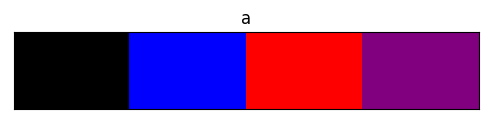

In [6]:
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("a", ["black", "blue", "red", "purple"], 4)

def plot_cmap(cmap, ncolor):
    """ 
    A convenient function to plot colors of a matplotlib cmap
 
    Args:
        ncolor (int): number of color to show
        cmap: a cmap object or a matplotlib color name
    """
 
    if isinstance(cmap, str):
        try:
            cm = plt.get_cmap(cmap)
        except ValueError:
            print("WARNINGS :", cmap, " is not a known colormap")
            cm = plt.cm.gray
    else:
        cm = cmap
 
    with mpl.rc_context(mpl.rcParamsDefault):
        fig = plt.figure(figsize=(6, 1), frameon=False)
        ax = fig.add_subplot(111)
        print(np.linspace(1, ncolor, ncolor).reshape(1, ncolor))
        ax.pcolor(np.linspace(1, ncolor, ncolor).reshape(1, ncolor), cmap=cm)
        ax.set_title(cm.name)
        xt = ax.set_xticks([])
        yt = ax.set_yticks([])
    return fig

print(my_cmap(2))
plot_cmap(my_cmap, 4)

In [7]:
def draw_bipartite(B, **kwargs):
    # Separate by group
    #l, r = nx.bipartite.sets(B)
    l = [n for n,d in B.nodes(data=True) if d.get('bipartite') == 0]
    r = [n for n,d in B.nodes(data=True) if d.get('bipartite') == 1]
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw(B, pos=pos, **kwargs)

def draw_12_tsp(G, **kwargs):
    pos = nx.get_node_attributes(G, 'pos')
    edge_color = [0 if G[i][j]['weight'] == 1 else 1 for (i, j) in G.edges]
    width = [0 if G[i][j]['weight'] == 1 else 4 for (i, j) in G.edges]
    alpha = [1 if G[i][j]['weight'] == 1 else 0.5 for (i, j) in G.edges]
    nx.draw(G, pos, with_labels=True,  \
            edge_color=edge_color, width=width, edge_cmap=rb_cmap, **kwargs)
    
    labels = dict([(edge, 2) for (edge, i) in nx.get_edge_attributes(G,'weight').items() if i == 2])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

In [8]:
# Самая простая реализация с перебором. На >10 вершинах работает бесконечно долго.
def solve_tsp(G):
    paths = itertools.permutations(list(G.nodes), G.number_of_nodes())
    
    min_weight = math.inf
    min_path = None
    count = 0
    for path in paths:
        count += 1
        if path[0] != 0:
            continue
        cur_weight = weight_of_path(G, path)
        if min_weight > cur_weight:
            min_weight = cur_weight
            min_path = path
    return min_weight, min_path

In [9]:
# Не нужна
def print_concorde_input(G):
    tsp_template = """
        TYPE : TSP
        DIMENSION : %i
        EDGE_WEIGHT_TYPE : EXPLICIT
        EDGE_WEIGHT_FORMAT : LOWER_DIAG_ROW 
        EDGE_WEIGHT_SECTION
        %s
        EOF
        """
    edges = [(u, v, G[u][v]['weight']) for (u, v) in G.edges]
    print(edges)
    return tsp_template%(G.number_of_vertices(), edges)

In [ ]:
# TODO: почему-то нет пути()
def generate_12_euclidean_TSP(n, side, n_iter, p1, p2):
    # TODO: для многих итераций точки могут совпадать.
    G = nx.Graph()
    for i in range(0, n):
        G.add_node(i)
        G.nodes[i]['pos'] = [random.uniform(0, side), random.uniform(0, side)]
    
    def intersect_circles(a, b, r_1, c, d, r_2):
        #Расстояние между центрами
        D = np.sqrt((c-a)**2+(d-b)**2)
        if not(r_1+r_2>D and D>np.abs(r_1-r_2)):
            return None

        delta = 1/4*np.sqrt((D+r_1+r_2)*(D+r_1-r_2)*(D-r_1+r_2)*(-D+r_1+r_2))

        x = (a+c)/2+(c-a)*(r_1**2-r_2**2)/(2*D**2)
        x_add = 2*(b-d)/D**2*delta
        y = (b+d)/2+(d-b)*(r_1**2-r_2**2)/(2*D**2)
        y_add = 2*(a-c)/D**2*delta

        return ((x+x_add, y-y_add),(x-x_add, y+y_add))

    def draw_edge(u, v, r):
        if random.uniform(0, 1)<p2:
                    G.add_edge(u, v, weight=r)
    
    def check_intersection(a, b, c, d, r):
        points = intersect_circles(a, b, r, c, d, r)
        if points is not None:
            if random.uniform(0, 1)<p1:
                new_node = G.number_of_nodes()
                G.add_node(new_node, pos=points[0])
                
                draw_edge(i, new_node, r)
                draw_edge(j, new_node, r)
            if random.uniform(0, 1)<p1:
                new_node = G.number_of_nodes()
                G.add_node(new_node, pos=points[1])
                
                draw_edge(i, new_node, r)
                draw_edge(j, new_node, r)
            #print(i, j, points)
    
    for cur_iter in range(0, n_iter):
        for i in range(0, n):
            for j in range(0, i):
                a, b = G.nodes[i]['pos']
                c, d = G.nodes[j]['pos']
                check_intersection(a, b, c, d, 1)
                check_intersection(a, b, c, d, 2)
    
    # Удалям все висячие вершины.
    deletes = True
    while deletes:
        deletes = False
        to_delete = []
        for n in G.nodes():
            if len(G.edges(n))<=1:
                to_delete.append(n)
                deletes = True
        G.remove_nodes_from(to_delete)

    return G

G = None
while True:
    G = generate_12_euclidean_TSP(20, 10, 1, 0.3, 1)
    #draw_weighted_graph(G, with_labels=True)
    #print(G.number_of_nodes(), G.number_of_edges())
    try:
        n, path = solve_with_concorde(G)
        #print(weight_of_path(G, path))
        if weight_of_path(G, path) < math.inf:
            break
    except Exception:
        pass
    #print(weight_of_path(G, path))
    #print([G.nodes[i] for i in range(G.number_of_nodes())])
plt.figure(figsize=(15, 10))
draw_weighted_graph(G, with_labels=True)

In [ ]:
# Вообще бред какой-то
def generate_12_euclidean_TSP(n_init, side, n_iter, p1, p2):
        
    def get_node_at_pos(G, pos):
        for a in G.nodes:
            if G.nodes[a]['pos'][0] == pos[0] and G.nodes[a]['pos'][1] == pos[1]:
                return a
        return None

    def insert_to_pos(G, node, pos):
        a = get_node_at_pos(G, pos)
        if a is None and random.uniform(0, 1) < p1:
            added = G.number_of_nodes()
            G.add_node(added, pos=pos)
            G.add_edge(node, added, weight=1)
        elif a is not None and random.uniform(0, 1) < p2:
            pass
#         for (u, v) in G.edges:
#                 if 
    
    def draw_edge(G, n, r, p, pos):
        if random.uniform(0, 1) < p:
            a = get_node_at_pos(G, pos)
            if a is not None and not G.has_edge(n, a):
                G.add_edge(n, a, weight=r)
            
    def draw_edges(G, n, r, p):
        d = G.nodes[n]
        draw_edge(G, n, r, p, (d['pos'][0]-r, d['pos'][1]))
        draw_edge(G, n, r, p, (d['pos'][0]+r, d['pos'][1]))
        draw_edge(G, n, r, p, (d['pos'][0], d['pos'][1]-r))
        draw_edge(G, n, r, p, (d['pos'][0], d['pos'][1]+r))
    
    G = nx.Graph()
    for i in range(0, n_init):
        pos = [random.randint(0, side), random.randint(0, side)]
        if get_node_at_pos(G, pos) is not None:
            continue
        added = G.number_of_nodes()
        G.add_node(added)
        G.nodes[added]['pos'] = pos
    
    for i in range(0, n_iter):
        n = random.randint(0, G.number_of_nodes()-1)
        draw_edges(G, n, 1, p1)
        draw_edges(G, n, 2, p2)
#         d = G.nodes[node]

#         insert_to_pos(G, node, (d['pos'][0]-1, d['pos'][1]))
#         insert_to_pos(G, node, (d['pos'][0]+1, d['pos'][1]))
#         insert_to_pos(G, node, (d['pos'][0], d['pos'][1]-1))
#         insert_to_pos(G, node, (d['pos'][0], d['pos'][1]+1))
    
    print(G.number_of_nodes(), G.number_of_edges())
    deletes = True
    while deletes:
        deletes = False
        to_delete = []
        for n in G.nodes():
            if len(G.edges(n))<=1:
                to_delete.append(n)
                deletes = True
        for n in to_delete:
            G.remove_edges_from(list(G.edges(n)))
        G.remove_nodes_from(to_delete)
        
    print(G.number_of_nodes(), G.number_of_edges())
    return G

G = None
while True:
    G = generate_12_euclidean_TSP(100, 10, 150, 0.8, 0.5)
    #draw_weighted_graph(G, with_labels=True)
#     G = nx.generators.random_geometric_graph(n=30, radius=0.3)
#     for (u, v) in G.edges():
#         G[u][v]['weight'] = random.randint(1, 2)
    #print(G.number_of_nodes(), G.number_of_edges())
    try:
        n, path = solve_with_concorde(G)
        #print(weight_of_path(G, path))
        if weight_of_path(G, path) < math.inf:
            break
    except Exception:
        pass
    #print(weight_of_path(G, path))
    #print([G.nodes[i] for i in range(G.number_of_nodes())])
plt.figure(figsize=(15, 10))
draw_weighted_graph(G, with_labels=True)

In [ ]:
def get_node_at_pos(G, pos):
    for a in G.nodes:
        if G.nodes[a]['pos'][0] == pos[0] and G.nodes[a]['pos'][1] == pos[1]:
            return a
    return None

def generate_walk(n, p1, p2):
    G = nx.Graph()
    pos = (0, 0)
    G.add_node(0, pos=pos)
    
    for i in range(1, n):
        r = 1 if random.uniform(0, 1) < p2 else 2
        pos_ = None
        while True:
            pr = random.uniform(0, 1)
            if pr < 0.25:
                pos_ = (pos[0]-r, pos[1])
            elif pr<0.5:
                pos_ = (pos[0]+r, pos[1])
            elif pr<0.75:
                pos_ = (pos[0], pos[1]-r)
            else:
                pos_ = (pos[0], pos[1]+r)
            if get_node_at_pos(G, pos_) is None:
                print(pos_)
                break
        G.add_node(i, pos=pos_)
        G.add_edge(i, i-1, weight=r)
        pos = pos_
    
    draw_weighted_graph(G, with_labels=True)
    return G

generate_walk(20, 0.5, 0.5)

In [ ]:
def powerset(iterable):
    xs = list(iterable)
    # note we return an iterator rather than a list
    return itertools.chain.from_iterable(itertools.combinations(xs,n) for n in range(len(xs)+1))

def manhattan_distance(G, i, j):
    posi = G.nodes[i]['pos']
    posj = G.nodes[j]['pos']
    return math.fabs(posi[0]-posj[0])+math.fabs(posi[1]-posj[1])

def to_12_tsp_manhattan(G):
    G_ = G.copy()
    for i in G_.nodes():
        for j in G_.nodes():
            if i != j and manhattan_distance(G, i, j) == 2:
                    if not G_.has_edge(i, j):
                        G_.add_edge(i, j, weight=2)
    return G_


In [ ]:
def generate_p_shaped(n, p1, p2):
    G = nx.Graph()
    
    for i in range(-1, n):
        for j in range(0, 4):
            G.add_node((j, i), pos=(j, i))
    
    for i in range(0, n-1):
        for j in range(0, 4):
            G.add_edge((j, i),(j, i+1),weight=1)
    
    G.add_edge((0, n-1), (1, n-1), weight=1)
    G.add_edge((2, n-1), (3, n-1), weight=1)
    G.add_edge((1, 0), (2, 0), weight=1)
    G.add_edge((0, 0), (0, -1), weight=1)
    G.add_edge((3, 0), (3, -1), weight=1)
    G.add_edge((0, -1), (1, -1), weight=1)
    for i in range(0, 3):
        G.add_edge((i, -1), (i+1, -1), weight=1)
    for i in range(1, n):
        for j in range(0, 3):
            if random.uniform(0, 1) < p1:
                G.add_edge((j, i), (j+1, i), weight=1)
    #for i in range(1, n):
    #    for j in range(0, 2):
    #        if random.uniform(0, 1) < p2:
    #            G.add_edge((j, i), (j+2, i), weight=2)
    return G


G = generate_p_shaped(3, 0.5, 0.5)
print(G.number_of_nodes(), G.number_of_edges())
process_tsp_manual(G, draw=False)

In [ ]:
def gen_grid(n, m, p):
    G = nx.Graph()
    for i in range(0, n):
        for j in range(0, m):
            G.add_node((i, j), pos=(i, j))
    def add_edges(n, m, r):
        n -= r
        m -= r
        for i in range(0, n):
            for j in range(0, m):
                if random.uniform(0, 1) < p:
                    G.add_edge((i, j), (i+r,j), weight=r)
                if random.uniform(0, 1) < p:
                    G.add_edge((i, j), (i,j+r), weight=r)
        for i in range(0, n):
            if random.uniform(0, 1) < p:
                G.add_edge((i, m), (i+r, m), weight=r)
        for j in range(0, m):
            if random.uniform(0, 1) < p:
                G.add_edge((n, j), (n, j+r), weight=r)
    add_edges(n, m, 1)
    add_edges(n, m, 2)
    #draw_weighted_graph(G, with_labels=True)
    G = set_edges_weight(G)
    return G
process_tsp_manual(gen_grid(4,4, 0.5))

In [ ]:
for j in range(0,40):
    K = min(j, 15)
    itern = int(sum([comb(j, i) for i in range(0, K+1)])-j-1)
    print(r"%s & %s & %s\\ \hline"%(j, itern, itern//1500//60))

In [ ]:
def improv(K, G, draw=False, simple=False, desired=None):
    """Алгоритм K-IMPROV
    draw может работать плохо из-за каких-то багов с colormap'ами в networkx"""
    if simple:
        if K > G.number_of_edges():
            K = G.number_of_edges()
    else:
        if K > G.number_of_nodes():
            K = G.number_of_nodes()
            
    # Изначально A пусто
    A = nx.Graph()
    A.add_nodes_from(G.nodes)
    A_components_num = sys.maxsize
    A_vertices_in_cycles_num = sys.maxsize
    A_singletons_num = sys.maxsize
    
    # Перебираем все возможные варианты для C
    log.info('Граф с %d вершинами и %d рёбрами'%(G.number_of_nodes(), G.number_of_edges()))
    if simple:
        max_iter = sum([comb(G.number_of_edges(), i) for i in range(0, K+1)])-G.number_of_edges()-1
    else:
        max_iter = sum([comb(G.number_of_nodes(), i) for i in range(0, K+1)])-G.number_of_nodes()-1
    log.info('Число комбинаций для перебора %d при K=%d'%(max_iter, K))
    
    n_global_iter = 0
    something_changes = True
    last_modification_iter, last_modification_global_iter = 0, 1
    while something_changes:
        n_global_iter += 1
        log.info('             GLOBAL ITERATION %d'%n_global_iter)
        something_changes = False
        if simple:
            C_edges_s = itertools.chain.from_iterable(itertools.combinations(G.edges, i) 
                                                      for i in range(1, K+1))
        else:
            C_nodes_s = itertools.chain.from_iterable(itertools.combinations(G.nodes, i) 
                                                      for i in range(2, K+2))
            C_edges_s = map(lambda C_nodes: get_chain_on_nodes(G, C_nodes),C_nodes_s)
        
        if log.getLogger().isEnabledFor(log.INFO):
            pbar = tqdm.tqdm_notebook(total=max_iter)
        exiting = False
        for n_iter, C_edges in enumerate(C_edges_s):
            if log.getLogger().isEnabledFor(log.INFO):
                pbar.update(1)
            
            if last_modification_global_iter < n_global_iter and n_iter > last_modification_iter:
                log.info("Early exit: nothing to check")
                break
            if C_edges == set():
                continue
            
            C = nx.Graph()
            C.add_nodes_from(G.nodes)
            C.add_edges_from(C_edges)
            G_new = nx.symmetric_difference(A, C)

            cur_components_num, cur_vertices_in_cycles_num, cur_singletons_num = get_components_count(G_new)

            if check_if_matching(G_new, 2):
                if (cur_components_num<A_components_num) \
                        or (cur_components_num == A_components_num \
                            and cur_vertices_in_cycles_num > A_vertices_in_cycles_num) \
                        or (cur_components_num == A_components_num \
                            and cur_vertices_in_cycles_num == A_vertices_in_cycles_num \
                            and cur_singletons_num < A_singletons_num):
                    something_changes = True
                    log.info('Changing A: %d %d %d'%( cur_components_num, cur_vertices_in_cycles_num, cur_singletons_num))
                    log.debug('was: %d %d %d'%( A_components_num, A_vertices_in_cycles_num, A_singletons_num))
                    last_modification_iter = n_iter
                    last_modification_global_iter = n_global_iter

                    # Баг networkx: если вставить рисовалку сюда, первый раз будет неправильный цвет.
    
                    A = G_new
                    A_components_num = cur_components_num
                    A_vertices_in_cycles_num = cur_vertices_in_cycles_num
                    A_singletons_num = cur_singletons_num
                    
                    # Сделаем выход пораньше, чтобы тестилось побыстрее
                    algo_ans = G.number_of_nodes()+A_components_num
                    if desired is not None:
                        if algo_ans < 8/7*desired:
                            exiting=True
                            log.info('K=%d was enough'%C.number_of_edges())
                            break
                        
                    if draw:
                        edge_color = [choose_color(edge, A, C) for edge in G.edges ]
                        plt.figure(figsize=(5,5))
                        draw_weighted_graph(G, edge_color=edge_color, width=4, edge_cmap=rb_cmap)
                        plt.show()
        if log.getLogger().isEnabledFor(log.INFO):
            pbar.close()
        if exiting:
            break

    algo_ans = G.number_of_nodes()+A_components_num
    if A_components_num == 1 and A_vertices_in_cycles_num > 0:
        algo_ans -= 1
    #nx.draw(A, with_labels=True)
    #plt.show()
    return algo_ans, A, C.number_of_edges()